In [190]:
import numpy as np
import pandas as pd
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import copy
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer 
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import joblib
from imblearn.over_sampling import SMOTE

import os
if not os.path.exists('CSV_files'):
    os.mkdir('CSV_files')
if not os.path.exists('models'):
    os.mkdir('models')
warnings.simplefilter(action='ignore', category=FutureWarning)

# set = True if want to Oversampling with SMOTE
is_smote = False

# Prepare data

In [191]:
app_train = pd.read_csv('./dataset/train.csv')
original_test = pd.read_csv('./dataset/test.csv')
app_test = copy.deepcopy(original_test)
print('app_train shape',app_train.shape)
print('app_test shape',app_test.shape)

app_train shape (13293, 156)
app_test shape (4422, 155)


/home/hungphan/miniconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [192]:
app_train.isnull().sum()


index                                                 0
hashed_factory_id                                     0
country                                              67
hashed_type_of_inspection                            68
style_number                                         71
                                                     ..
factory_product_measurement_minor_defect_rate_60      0
factory_product_measurement_minor_defect_rate_90      0
factory_product_measurement_minor_defect_rate_120     0
factory_product_measurement_minor_defect_rate_150     0
label                                                 0
Length: 156, dtype: int64

In [193]:
app_train['label'].value_counts()


0    12641
1      652
Name: label, dtype: int64

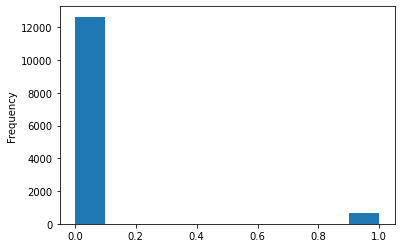

In [194]:
app_train['label'].astype(int).plot.hist();


In [195]:
app_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13293 entries, 0 to 13292
Columns: 156 entries, index to label
dtypes: float64(145), int64(2), object(9)
memory usage: 15.8+ MB


# Preprocessing data
## Remove columns with unique values 

In [196]:
app_train.drop('index',inplace=True,axis=1)
train_unique_columns = []
for col in app_train.columns:
    if len(app_train[col].unique()) == 1:
        train_unique_columns.append(col)
        app_train.drop(col,inplace=True,axis=1)
app_test.drop('index',inplace=True,axis=1)

for col in train_unique_columns:
    app_test.drop(col,inplace=True,axis=1)
print("app_train shape:", app_train.shape)
print("app_test shape:", app_test.shape)

app_train shape: (13293, 115)
app_test shape: (4422, 114)


In [197]:
def missing_values_table(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)
    print ("lected dataframe has " + str(df.shape[1]) + " columns.\n"      
        "There are " + str(mis_val_table_ren_columns.shape[0]) +
          " columns that have missing values.")
    return mis_val_table_ren_columns

In [198]:
print("app_train missing value")
missing_values = missing_values_table(app_train)
missing_values.head(20)



app_train missing value
lected dataframe has 115 columns.
There are 7 columns that have missing values.


,Missing Values,% of Total Values
style_number,71,0.5
hashed_product_category,69,0.5
hashed_type_of_inspection,68,0.5
country,67,0.5
brand_number,61,0.5
item_number,59,0.4
hashed_product_line,58,0.4


In [199]:
print("app_test missing value")
missing_values = missing_values_table(app_test)
missing_values.head(20)



app_test missing value
lected dataframe has 114 columns.
There are 7 columns that have missing values.


,Missing Values,% of Total Values
hashed_product_line,27,0.6
hashed_type_of_inspection,24,0.5
brand_number,22,0.5
item_number,21,0.5
style_number,19,0.4
country,18,0.4
hashed_product_category,18,0.4


In [200]:
catagory_features_keep_min_freequency_from_visualize = {'country': 5,
 'hashed_factory_id': 1,
 'hashed_type_of_inspection': 134,
 'style_number': 2,
 'item_number': 2,
 'brand_number': 5,
 'hashed_product_line': 7,
 'hashed_product_category': 3,
 'hashed_product_id': 1}

## Fill NAN values and remove the values with a frequency smaller threshold and assign them with other class

In [201]:
missing_value_in_columns = missing_values.index.to_list()
for idx,column in enumerate(missing_value_in_columns):    
    app_train[column] = app_train[column].fillna('Unknown')
    app_test[column] = app_test[column].fillna('Unknown')
#     app_train[column] = app_train[column].fillna(app_train[column].value_counts().index[0])
#     app_test[column] = app_test[column].fillna(app_test[column].value_counts().index[0])
    use_values = (app_train[column].value_counts().loc[lambda x : x>catagory_features_keep_min_freequency_from_visualize[column]]).index.tolist()
    for i in range(app_train.shape[0]):
        if app_train[column][i] not in use_values:
            if app_train[column][i] != 'Unknown':
                app_train[column][i] = 'Other' + str(idx)
    for i in range(app_test.shape[0]):
        if app_test[column][i] not in use_values:
            if app_test[column][i] != 'Unknown':
                app_test[column][i] = 'Other' + str(idx)


<ipython-input-201-54f6bb3882a1>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_train[column][i] = 'Other' + str(idx)
<ipython-input-201-54f6bb3882a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_test[column][i] = 'Other' + str(idx)
<ipython-input-201-54f6bb3882a1>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_train[column][i] = 'Other' + str(idx)
<ipython-input-201-54f6bb3882a1>:15: SettingWithCopyWarning: 
A v

In [202]:
missing_values = missing_values_table(app_train)
missing_values.head(20)
app_train

lected dataframe has 115 columns.
There are 0 columns that have missing values.


,hashed_factory_id,country,hashed_type_of_inspection,style_number,item_number,brand_number,factory_inspection_fail_rate_30,factory_inspection_fail_rate_60,factory_inspection_fail_rate_90,factory_inspection_fail_rate_120,...,factory_product_packaging_major_defect_rate_60,factory_product_packaging_major_defect_rate_90,factory_product_packaging_major_defect_rate_120,factory_product_packaging_major_defect_rate_150,factory_product_packaging_minor_defect_rate_30,factory_product_packaging_minor_defect_rate_60,factory_product_packaging_minor_defect_rate_90,factory_product_packaging_minor_defect_rate_120,factory_product_packaging_minor_defect_rate_150,label
0,009f006e3799f9fe96a0c95e944df3e669f02d4e,Vietnam,e06d28d1365467625ebfa999328501705a3398bb,1,8,1.0,0.000000,0.032258,0.028571,0.027778,...,0.004545,0.004545,0.004545,0.004545,0.0,0.0,0.0,0.0,0.0,0
1,a9f2640fbd054cb52bf9411b7a42f668a9613197,Vietnam,e06d28d1365467625ebfa999328501705a3398bb,1,5,1.0,0.000000,0.200000,0.035714,0.020408,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0
2,c0bffcf0318c483b2dbb1c56bed6efa58f9717bd,Pakistan,e06d28d1365467625ebfa999328501705a3398bb,1,8,Unknown,0.000000,0.000000,0.000000,0.000000,...,0.000444,0.000400,0.000400,0.000400,0.0,0.0,0.0,0.0,0.0,0
3,c96f3f1c47dca83af551893a28c3409cb4afd31d,Guatemala,e06d28d1365467625ebfa999328501705a3398bb,2,12,1.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0
4,63ffdba896c8bb150eca939d1eb7e3bd4e732ed4,Pakistan,e06d28d1365467625ebfa999328501705a3398bb,1,2,1.0,0.000000,0.000000,0.000000,0.100000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13288,009f006e3799f9fe96a0c95e944df3e669f02d4e,Vietnam,e06d28d1365467625ebfa999328501705a3398bb,1,15,1.0,0.000000,0.000000,0.022222,0.021277,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0
13289,9213adcfaa233c1bd362eeaaef15269b1f15afe1,Nicaragua,e06d28d1365467625ebfa999328501705a3398bb,1,18,1.0,0.015385,0.009174,0.012195,0.010870,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0
13290,5a06094857c4e9b5bd124cf37a6e7d336bb8edd4,Cambodia,e06d28d1365467625ebfa999328501705a3398bb,3,20,1.0,0.071429,0.053571,0.045977,0.039604,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0
13291,a9f2640fbd054cb52bf9411b7a42f668a9613197,Vietnam,e06d28d1365467625ebfa999328501705a3398bb,9,33,1.0,0.000000,0.000000,0.023529,0.018868,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0


In [203]:
missing_values = missing_values_table(app_test)
missing_values.head(20)
app_test

lected dataframe has 114 columns.
There are 0 columns that have missing values.


,hashed_factory_id,country,hashed_type_of_inspection,style_number,item_number,brand_number,factory_inspection_fail_rate_30,factory_inspection_fail_rate_60,factory_inspection_fail_rate_90,factory_inspection_fail_rate_120,...,factory_product_packaging_major_defect_rate_30,factory_product_packaging_major_defect_rate_60,factory_product_packaging_major_defect_rate_90,factory_product_packaging_major_defect_rate_120,factory_product_packaging_major_defect_rate_150,factory_product_packaging_minor_defect_rate_30,factory_product_packaging_minor_defect_rate_60,factory_product_packaging_minor_defect_rate_90,factory_product_packaging_minor_defect_rate_120,factory_product_packaging_minor_defect_rate_150
0,57e6f82ac38828e1c4cc9a6ff415a5ad2fa94507,China,e06d28d1365467625ebfa999328501705a3398bb,1,20,1.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
1,67bc0575f067a61d385539a2169c649814accea7,Nicaragua,4a31b54c7b1ada762e54a711dc598073de477352,1,18,1.0,0.031250,0.032258,0.071429,0.070175,...,0.000333,0.000161,0.000094,0.000085,0.000085,0.0,0.0,0.0,0.0,0.0
2,ab1e388558d6ea7093a4f7912cd1381e2a2962ae,China,e06d28d1365467625ebfa999328501705a3398bb,1,8,1.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
3,8e0114f5d7c26b37cec7f58a197a93bbc49e14a6,Vietnam,e06d28d1365467625ebfa999328501705a3398bb,1,10,1.0,0.007407,0.003937,0.002865,0.002331,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
4,52ef0901f440dc5f007c4f8d79eff436d79da852,Vietnam,e06d28d1365467625ebfa999328501705a3398bb,1,7,1.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4417,b6f1eddfb2a0695fe5d8cd3fdb8f5e5db2d0efc3,Vietnam,e06d28d1365467625ebfa999328501705a3398bb,2,Other3,1.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
4418,864a334df4c3602dc835dfba496cde1056374bbd,China,e06d28d1365467625ebfa999328501705a3398bb,1,Other3,1.0,0.000000,0.000000,0.000000,0.009009,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
4419,cd2bf6a940623a271e2e425d95d7689c2db69e9f,China,e06d28d1365467625ebfa999328501705a3398bb,2,Unknown,1.0,0.055556,0.031250,0.025641,0.020000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
4420,cd2bf6a940623a271e2e425d95d7689c2db69e9f,China,e06d28d1365467625ebfa999328501705a3398bb,2,Other3,1.0,0.055556,0.031250,0.025641,0.020000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


In [204]:
app_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13293 entries, 0 to 13292
Columns: 115 entries, hashed_factory_id to label
dtypes: float64(105), int64(1), object(9)
memory usage: 11.7+ MB


In [205]:
app_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4422 entries, 0 to 4421
Columns: 114 entries, hashed_factory_id to factory_product_packaging_minor_defect_rate_150
dtypes: float64(105), object(9)
memory usage: 3.8+ MB


In [206]:
app_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)
app_test.select_dtypes('object').apply(pd.Series.nunique, axis = 0)


hashed_factory_id            266
country                       17
hashed_type_of_inspection      6
style_number                  16
item_number                   84
brand_number                   5
hashed_product_line            4
hashed_product_category       38
hashed_product_id            103
dtype: int64

## Remove columns with the correlated features

In [207]:
# Create correlation matrix
corr_matrix = app_train.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# Drop features 
app_train.drop(to_drop, axis=1, inplace=True)
app_test.drop(to_drop, axis=1, inplace=True)
print("training shape", app_train.shape)
print("testing shape", app_test.shape)


training shape (13293, 46)
testing shape (4422, 45)


In [208]:
labels =  app_train['label']
app_train = app_train.drop('label', axis=1)
print("training shape", app_train.shape)


training shape (13293, 45)


# Using Categorical Data with One Hot Encoding


In [209]:

object_cols = app_train.select_dtypes(include = "object").columns.to_list()
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(app_train[object_cols]))
# OH_cols_test = pd.DataFrame(OH_encoder.transform(app_test[object_cols].astype(str)))
OH_cols_test = pd.DataFrame(OH_encoder.transform(app_test[object_cols]))
# One-hot encoding removed index; put it back
OH_cols_train.index = app_train.index
OH_cols_test.index = app_test.index
# Remove categorical columns (will replace with one-hot encoding)
num_X_train = app_train.drop(object_cols, axis=1)
num_X_test = app_test.drop(object_cols, axis=1)
# Add one-hot encoded columns to numerical features
OH_X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
OH_X_test = pd.concat([num_X_test, OH_cols_test], axis=1)
data = OH_X_train
app_test = OH_X_test
print(data.shape)
print(app_test.shape)

(13293, 674)
(4422, 674)


# Transform data


In [210]:
features = list(data.columns)
# imputer = SimpleImputer(strategy = 'median')
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
scaler = MinMaxScaler(feature_range = (0, 1))
imputer.fit(data)
data = imputer.transform(data)
app_test = imputer.transform(app_test)
scaler.fit(data)
data = scaler.transform(data)
app_test = scaler.transform(app_test)
print('Training data shape: ', data.shape)
print('Testing data shape: ', app_test.shape)
data

Training data shape:  (13293, 674)
Testing data shape:  (4422, 674)


array([[0.        , 0.03225806, 0.02857143, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.2       , 0.03571429, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.07142857, 0.05357143, 0.04597701, ..., 0.        , 0.        ,
        1.        ],
       [0.        , 0.        , 0.02352941, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.02352941, ..., 0.        , 0.        ,
        0.        ]])

# Oversampling with SMOTE

In [211]:
if is_smote:
    data,labels=SMOTE().fit_resample(data,labels.values.ravel())


# Training and evaluation split

In [212]:
X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=11)

# Training logistic regression model

In [213]:
log_reg = LogisticRegression(C = 0.0001, verbose=True, tol=0.00005)
log_reg.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


LogisticRegression(C=0.0001, tol=5e-05, verbose=True)

In [214]:
filename = './models/LogisticRegression_80_20.sav'
joblib.dump(log_reg, filename)

['./models/LogisticRegression_80_20.sav']

# Function report evaluation results and saves to CSV file

In [215]:
def report_result_and_save_CSV(X_val, y_val, model, is_save_csv,original_test, app_test_, name_csv):
    y_pred = model.predict_proba(X_val)[:,1]
    precision, recall, thresholds = precision_recall_curve(y_val, y_pred)
    fscore = (2 * precision * recall) / (precision + recall)
    ix = -1
    max_score = 0
    for idx, score in enumerate(fscore):
        if score > max_score:
            max_score = score
            ix = idx

    print('threshold: ', thresholds[ix], 'Best_fscore:',fscore[ix])
    temp = copy.deepcopy(y_pred)
    temp[temp>=thresholds[ix]] = 1
    temp[temp<thresholds[ix]] = 0
    print(classification_report(y_val, temp))
    print("Precision:\t", metrics.precision_score(y_val, temp))
    print("Recall:\t\t", metrics.recall_score(y_val, temp))
    print("F1:\t\t", metrics.f1_score(y_val, temp))
    print("Accuracy:\t", metrics.accuracy_score(y_val, temp))
    print("Confusion matrix:\n",metrics.confusion_matrix(y_val, temp))
    submit = None
    if is_save_csv:
        test_pred = model.predict_proba(app_test_)[:, 1]
        temp = copy.deepcopy(test_pred)
        temp[temp>=thresholds[ix]] = 1
        temp[temp<thresholds[ix]] = 0
        submit = original_test
        submit['TARGET'] = temp
        submit.to_csv('./CSV_files/{}.csv'.format(name_csv), index = False)
        print(submit.shape)
    return submit, thresholds[ix]




# Result submit test data 

In [216]:
submit, _ = report_result_and_save_CSV(X_val, y_val, log_reg, True, original_test, app_test,"LogisticRegression_80_20")
submit

<ipython-input-215-70176783c208>:4: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


threshold:  0.04865847923374146 Best_fscore: 0.26108374384236455
              precision    recall  f1-score   support

           0       0.96      0.92      0.94      2513
           1       0.20      0.36      0.26       146

    accuracy                           0.89      2659
   macro avg       0.58      0.64      0.60      2659
weighted avg       0.92      0.89      0.90      2659

Precision:	 0.20384615384615384
Recall:		 0.363013698630137
F1:		 0.26108374384236455
Accuracy:	 0.8871756299360662
Confusion matrix:
 [[2306  207]
 [  93   53]]
(4422, 156)


,index,hashed_factory_id,country,hashed_type_of_inspection,style_number,item_number,brand_number,factory_inspection_fail_rate_30,factory_inspection_fail_rate_60,factory_inspection_fail_rate_90,...,factory_product_measurement_major_defect_rate_60,factory_product_measurement_major_defect_rate_90,factory_product_measurement_major_defect_rate_120,factory_product_measurement_major_defect_rate_150,factory_product_measurement_minor_defect_rate_30,factory_product_measurement_minor_defect_rate_60,factory_product_measurement_minor_defect_rate_90,factory_product_measurement_minor_defect_rate_120,factory_product_measurement_minor_defect_rate_150,TARGET
0,26,57e6f82ac38828e1c4cc9a6ff415a5ad2fa94507,China,e06d28d1365467625ebfa999328501705a3398bb,1,20,1.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,62,67bc0575f067a61d385539a2169c649814accea7,Nicaragua,4a31b54c7b1ada762e54a711dc598073de477352,1,18,1.0,0.031250,0.032258,0.071429,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,63,ab1e388558d6ea7093a4f7912cd1381e2a2962ae,China,e06d28d1365467625ebfa999328501705a3398bb,1,8,1.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,64,8e0114f5d7c26b37cec7f58a197a93bbc49e14a6,Vietnam,e06d28d1365467625ebfa999328501705a3398bb,1,10,1.0,0.007407,0.003937,0.002865,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,65,52ef0901f440dc5f007c4f8d79eff436d79da852,Vietnam,e06d28d1365467625ebfa999328501705a3398bb,1,7,1.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4417,20968,b6f1eddfb2a0695fe5d8cd3fdb8f5e5db2d0efc3,Vietnam,e06d28d1365467625ebfa999328501705a3398bb,2,16.0,1.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4418,20969,864a334df4c3602dc835dfba496cde1056374bbd,China,e06d28d1365467625ebfa999328501705a3398bb,1,30.0,1.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4419,20971,cd2bf6a940623a271e2e425d95d7689c2db69e9f,China,e06d28d1365467625ebfa999328501705a3398bb,2,NaN,1.0,0.055556,0.031250,0.025641,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4420,20972,cd2bf6a940623a271e2e425d95d7689c2db69e9f,China,e06d28d1365467625ebfa999328501705a3398bb,2,30.0,1.0,0.055556,0.031250,0.025641,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


0.0    4089
1.0     333
Name: TARGET, dtype: int64

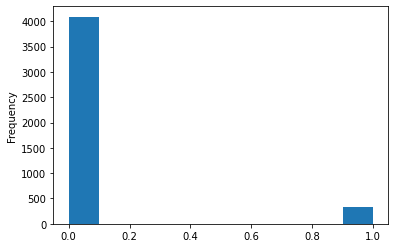

In [217]:
submit['TARGET'].astype(int).plot.hist();
submit['TARGET'].value_counts()


# Using Kfold for training and evaluation to choose the best model for each fold and compile all k-model by choosing the average result

In [218]:
def make_classification_logictis_regression():
    logictis_regression= LogisticRegression(C = 0.0001, verbose=True, tol=0.00005)
    return logictis_regression

In [219]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=11)

In [220]:
def model_kfold(kfold, data, labels, make_classification, model_name):
    list_model = []
    list_best_threshold = []
    count = 0 
    for train_ix, test_ix in kfold.split(data, labels):
        count += 1
        print("--------------------------------------")
        print("FOLD: {}".format(count))
        X_train_, X_val_ =  data[train_ix], data[test_ix]
        y_train_, y_val_ = labels[train_ix], labels[test_ix]
        model =None
        model = make_classification()
        model.fit(X_train_, y_train_)
        filename = './models/{}_fold_{}.sav'.format(model_name, count)
        joblib.dump(model, filename)
        _, threshold = report_result_and_save_CSV(X_val_, y_val_, model, False, '', '','')
        list_model.append(model)
        list_best_threshold.append(threshold)
    return list_model, list_best_threshold

def evaluat_all_data_or_submit(data, labels, list_model, list_best_threshold, is_submit=False, name_csv=None, original_test=None):
    list_result_pre = []
    for idx, model in enumerate(list_model):
        y_pred = model.predict_proba(data)[:,1]
        temp = copy.deepcopy(y_pred)
        temp[temp>=list_best_threshold[idx]] = 1
        temp[temp<list_best_threshold[idx]] = 0
        list_result_pre.append(temp)
        if labels is not None:
            print("Report result model_{}".format(idx+1))
            print(classification_report(labels, temp))
            print("Confusion matrix:\n",metrics.confusion_matrix(labels, temp))
    num_model = len(list_model)
    result_pre = [0] *len(list_result_pre[0])
    for idx in range(len(list_result_pre[0])):
        count_class = 0
        for idx_model in range(num_model):
            count_class += list_result_pre[idx_model][idx]
        if count_class >= (num_model//2 + 1):
            result_pre[idx] = 1
    if labels is not None:
        print("Final report avg kfold")
        print(classification_report(labels, result_pre))
        print("Confusion matrix:\n",metrics.confusion_matrix(labels, result_pre))
        
    submit = None
    if is_submit:
        submit = original_test
        submit['TARGET'] = result_pre
        submit.to_csv('./CSV_files/{}.csv'.format(name_csv), index = False)
    return submit

In [221]:
list_model, list_best_threshold = model_kfold(kfold, data, labels, make_classification_logictis_regression, 'LogisticRegression')

--------------------------------------
FOLD: 1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
<ipython-input-215-70176783c208>:4: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


threshold:  0.049673099899880786 Best_fscore: 0.23255813953488375
              precision    recall  f1-score   support

           0       0.97      0.86      0.91      2529
           1       0.15      0.50      0.23       130

    accuracy                           0.84      2659
   macro avg       0.56      0.68      0.57      2659
weighted avg       0.93      0.84      0.88      2659

Precision:	 0.15151515151515152
Recall:		 0.5
F1:		 0.23255813953488375
Accuracy:	 0.8386611508085746
Confusion matrix:
 [[2165  364]
 [  65   65]]
--------------------------------------
FOLD: 2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


threshold:  0.050251284275427986 Best_fscore: 0.24691358024691354
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      2528
           1       0.21      0.31      0.25       131

    accuracy                           0.91      2659
   macro avg       0.59      0.62      0.60      2659
weighted avg       0.93      0.91      0.92      2659

Precision:	 0.20725388601036268
Recall:		 0.3053435114503817
F1:		 0.24691358024691354
Accuracy:	 0.9082361790146671
Confusion matrix:
 [[2375  153]
 [  91   40]]
--------------------------------------
FOLD: 3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
<ipython-input-215-70176783c208>:4: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


threshold:  0.05010136607926262 Best_fscore: 0.22277227722772278
              precision    recall  f1-score   support

           0       0.96      0.91      0.94      2528
           1       0.16      0.34      0.22       131

    accuracy                           0.88      2659
   macro avg       0.56      0.63      0.58      2659
weighted avg       0.92      0.88      0.90      2659

Precision:	 0.16483516483516483
Recall:		 0.3435114503816794
F1:		 0.22277227722772278
Accuracy:	 0.881910492666416
Confusion matrix:
 [[2300  228]
 [  86   45]]
--------------------------------------
FOLD: 4


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
<ipython-input-215-70176783c208>:4: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


threshold:  0.050299475781561714 Best_fscore: 0.20963172804532576
              precision    recall  f1-score   support

           0       0.96      0.93      0.94      2528
           1       0.17      0.28      0.21       130

    accuracy                           0.90      2658
   macro avg       0.56      0.61      0.58      2658
weighted avg       0.92      0.90      0.91      2658

Precision:	 0.16591928251121077
Recall:		 0.2846153846153846
F1:		 0.20963172804532576
Accuracy:	 0.8950338600451467
Confusion matrix:
 [[2342  186]
 [  93   37]]
--------------------------------------
FOLD: 5
threshold:  0.05001577775841227 Best_fscore: 0.23244552058111384
              precision    recall  f1-score   support

           0       0.97      0.91      0.94      2528
           1       0.17      0.37      0.23       130

    accuracy                           0.88      2658
   macro avg       0.57      0.64      0.58      2658
weighted avg       0.93      0.88      0.90      2658

Preci

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
<ipython-input-215-70176783c208>:4: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


### Just for fun because evaluation at the traning dataset

In [222]:
evaluat_all_data_or_submit(data, labels, list_model, list_best_threshold) 


Report result model_1
              precision    recall  f1-score   support

           0       0.97      0.86      0.91     12641
           1       0.14      0.46      0.22       652

    accuracy                           0.84     13293
   macro avg       0.55      0.66      0.56     13293
weighted avg       0.93      0.84      0.87     13293

Confusion matrix:
 [[10810  1831]
 [  351   301]]
Report result model_2
              precision    recall  f1-score   support

           0       0.96      0.94      0.95     12641
           1       0.18      0.26      0.21       652

    accuracy                           0.90     13293
   macro avg       0.57      0.60      0.58     13293
weighted avg       0.92      0.90      0.91     13293

Confusion matrix:
 [[11845   796]
 [  482   170]]
Report result model_3
              precision    recall  f1-score   support

           0       0.96      0.91      0.94     12641
           1       0.16      0.32      0.22       652

    accuracy    

In [223]:
submit = evaluat_all_data_or_submit(app_test, None, list_model, list_best_threshold, is_submit=True, name_csv='Kfold_logistic_regression', original_test=original_test) 


0    4055
1     367
Name: TARGET, dtype: int64

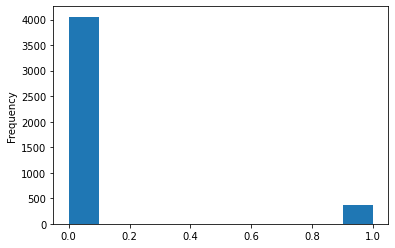

In [224]:
submit['TARGET'].astype(int).plot.hist();
submit['TARGET'].value_counts()


# Training Random Forest model

In [225]:
random_forest = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)
random_forest.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.4s finished


RandomForestClassifier(n_jobs=-1, random_state=50, verbose=1)

In [226]:
filename = './models/RandomForestClassifier_80_20.sav'
joblib.dump(random_forest, filename)

['./models/RandomForestClassifier_80_20.sav']

In [227]:
submit,_ = report_result_and_save_CSV(X_val, y_val, random_forest, True, original_test, app_test,"RandomForestClassifier_80_20")


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
<ipython-input-215-70176783c208>:4: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


threshold:  0.11 Best_fscore: 0.2977941176470589
              precision    recall  f1-score   support

           0       0.97      0.87      0.92      2513
           1       0.20      0.55      0.30       146

    accuracy                           0.86      2659
   macro avg       0.59      0.71      0.61      2659
weighted avg       0.93      0.86      0.89      2659

Precision:	 0.20351758793969849
Recall:		 0.5547945205479452
F1:		 0.2977941176470589
Accuracy:	 0.8563369687852577
Confusion matrix:
 [[2196  317]
 [  65   81]]
(4422, 156)


0.0    3668
1.0     754
Name: TARGET, dtype: int64

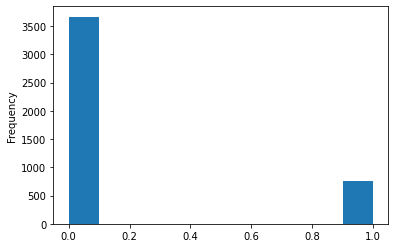

In [228]:
submit['TARGET'].astype(int).plot.hist();
submit['TARGET'].value_counts()

# Kfold Random Forest model

In [229]:
def make_classification_RandomForestClassifier():
    random_forest = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)
    return random_forest

In [230]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=22)

In [231]:
list_model, list_best_threshold = model_kfold(kfold, data, labels, make_classification_RandomForestClassifier, 'RandomForestClassifier')

--------------------------------------
FOLD: 1


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
<ipython-input-215-70176783c208>:4: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


threshold:  0.07 Best_fscore: 0.21703296703296704
              precision    recall  f1-score   support

           0       0.98      0.79      0.88      2529
           1       0.13      0.61      0.22       130

    accuracy                           0.79      2659
   macro avg       0.55      0.70      0.55      2659
weighted avg       0.93      0.79      0.84      2659

Precision:	 0.13210702341137123
Recall:		 0.6076923076923076
F1:		 0.21703296703296704
Accuracy:	 0.7856336968785258
Confusion matrix:
 [[2010  519]
 [  51   79]]
--------------------------------------
FOLD: 2


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


threshold:  0.12 Best_fscore: 0.2771855010660981
              precision    recall  f1-score   support

           0       0.97      0.89      0.93      2528
           1       0.19      0.50      0.28       131

    accuracy                           0.87      2659
   macro avg       0.58      0.69      0.60      2659
weighted avg       0.93      0.87      0.90      2659

Precision:	 0.19230769230769232
Recall:		 0.4961832061068702
F1:		 0.2771855010660981
Accuracy:	 0.8725084618277548
Confusion matrix:
 [[2255  273]
 [  66   65]]
--------------------------------------
FOLD: 3


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished
<ipython-input-215-70176783c208>:4: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


threshold:  0.09 Best_fscore: 0.2267343485617597
              precision    recall  f1-score   support

           0       0.97      0.84      0.90      2528
           1       0.15      0.51      0.23       131

    accuracy                           0.83      2659
   macro avg       0.56      0.68      0.57      2659
weighted avg       0.93      0.83      0.87      2659

Precision:	 0.14565217391304347
Recall:		 0.5114503816793893
F1:		 0.2267343485617597
Accuracy:	 0.8281308762692742
Confusion matrix:
 [[2135  393]
 [  64   67]]
--------------------------------------
FOLD: 4


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
<ipython-input-215-70176783c208>:4: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


threshold:  0.1 Best_fscore: 0.23486238532110096
              precision    recall  f1-score   support

           0       0.97      0.86      0.91      2528
           1       0.15      0.49      0.23       130

    accuracy                           0.84      2658
   macro avg       0.56      0.68      0.57      2658
weighted avg       0.93      0.84      0.88      2658

Precision:	 0.15421686746987953
Recall:		 0.49230769230769234
F1:		 0.23486238532110096
Accuracy:	 0.8431151241534989
Confusion matrix:
 [[2177  351]
 [  66   64]]
--------------------------------------
FOLD: 5


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s


threshold:  0.13 Best_fscore: 0.24942263279445728
              precision    recall  f1-score   support

           0       0.97      0.90      0.93      2528
           1       0.18      0.42      0.25       130

    accuracy                           0.88      2658
   macro avg       0.57      0.66      0.59      2658
weighted avg       0.93      0.88      0.90      2658

Precision:	 0.1782178217821782
Recall:		 0.4153846153846154
F1:		 0.24942263279445728
Accuracy:	 0.8777276147479308
Confusion matrix:
 [[2279  249]
 [  76   54]]


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


### Just for fun because evaluation at the traning dataset

In [232]:
evaluat_all_data_or_submit(data, labels, list_model, list_best_threshold) 


Report result model_1
              precision    recall  f1-score   support

           0       1.00      0.91      0.95     12641
           1       0.35      0.92      0.51       652

    accuracy                           0.91     13293
   macro avg       0.67      0.92      0.73     13293
weighted avg       0.96      0.91      0.93     13293

Confusion matrix:
 [[11518  1123]
 [   51   601]]


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Report result model_2


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s


              precision    recall  f1-score   support

           0       0.99      0.97      0.98     12641
           1       0.57      0.90      0.70       652

    accuracy                           0.96     13293
   macro avg       0.78      0.93      0.84     13293
weighted avg       0.97      0.96      0.97     13293

Confusion matrix:
 [[12207   434]
 [   66   586]]
Report result model_3
              precision    recall  f1-score   support

           0       0.99      0.94      0.97     12641
           1       0.44      0.90      0.60       652

    accuracy                           0.94     13293
   macro avg       0.72      0.92      0.78     13293
weighted avg       0.97      0.94      0.95     13293

Confusion matrix:
 [[11906   735]
 [   64   588]]


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


Report result model_4
              precision    recall  f1-score   support

           0       0.99      0.95      0.97     12641
           1       0.48      0.90      0.63       652

    accuracy                           0.95     13293
   macro avg       0.74      0.92      0.80     13293
weighted avg       0.97      0.95      0.96     13293

Confusion matrix:
 [[12015   626]
 [   66   586]]
Report result model_5
              precision    recall  f1-score   support

           0       0.99      0.97      0.98     12641
           1       0.61      0.88      0.72       652

    accuracy                           0.97     13293
   macro avg       0.80      0.93      0.85     13293
weighted avg       0.97      0.97      0.97     13293

Confusion matrix:
 [[12268   373]
 [   76   576]]
Final report avg kfold
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     12641
           1       0.64      1.00      0.78       652

    accuracy   

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


In [233]:
submit = evaluat_all_data_or_submit(app_test, None, list_model, list_best_threshold, is_submit=True, name_csv='Kfold_RandomForestClassifier', original_test=original_test) 


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

0    3525
1     897
Name: TARGET, dtype: int64

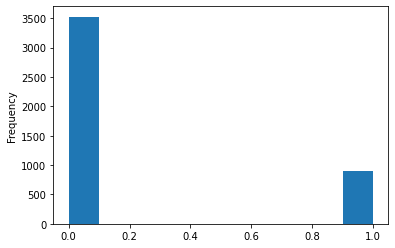

In [234]:
submit['TARGET'].astype(int).plot.hist();
submit['TARGET'].value_counts()